100%|██████████| 2000/2000 [13:18<00:00,  2.51it/s]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.1073 - loss: 3.6094 - val_accuracy: 0.0375 - val_loss: 3.7996
Epoch 2/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.2907 - loss: 2.4995 - val_accuracy: 0.0775 - val_loss: 3.6016
Epoch 3/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.4048 - loss: 2.0380 - val_accuracy: 0.1150 - val_loss: 3.3852
Epoch 4/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.4594 - loss: 1.7993 - val_accuracy: 0.1425 - val_loss: 3.1759
Epoch 5/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.5118 - loss: 1.6444 - val_accuracy: 0.2225 - val_loss: 3.0680
Epoch 6/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.5473 - loss: 1.4538 - val_accuracy: 0.2125 - val_loss: 3.1153
Epoch 7/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.6043 - loss: 1.2750 - val_accuracy: 0.1800 - val_loss: 3.3687
Epoch 8/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.5870 - loss: 1.3037 - val_accuracy: 0.3325 - v

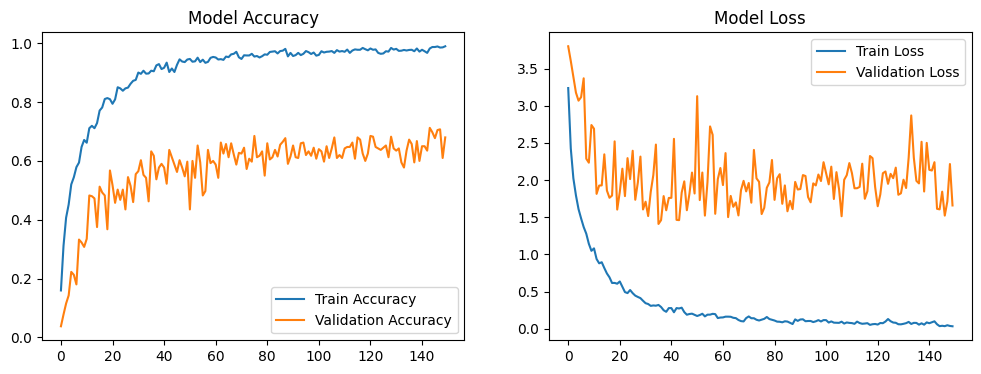

Training Accuracy: 0.9775
Validation Accuracy: 0.6800
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 213ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.83      0.83         6
           1       1.00      1.00      1.00         6
           2       0.75      0.33      0.46         9
           3       0.68      1.00      0.81        13
           4       0.89      0.73      0.80        11
           5       0.78      0.58      0.67        12
           6       0.75      0.75      0.75        12
           7       0.38      0.83      0.53         6
           8       0.64      0.70      0.67        10
           9       0.71      0.83      0.77         6
          10       0.33      0.80      0.47         5
          11       0.71      0.83      0.77        12
          12       0.60      0.67      0.63         9
          13       0.80      0.67      0.73         6
          14       0.67      0.67      0.67         6
          15       0.58      0.50      0.54        14
          16       0.83      0.56      0.67         9
  

In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Load ESC-50 metadata
esc50_csv_path = "/content/drive/MyDrive/Colab Notebooks/Dataset/ESC-50-master/meta/esc50.csv"
esc50_audio_dir = "/content/drive/MyDrive/Colab Notebooks/Dataset/ESC-50-master/audio"

metadata = pd.read_csv(esc50_csv_path)

def extract_features(file_path, sr=22050, n_mels=128, n_mfcc=40, target_size=(128, 128)):
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return None
    try:
        y, sr = librosa.load(file_path, sr=sr, duration=3.0)

        # Skip very short audio
        if len(y) < sr * 0.1:
            print(f"Skipping short audio file: {file_path}")
            return None

        # Compute Log-Mel Spectrogram
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

        # Compute MFCC
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

        # Resize both to (128, 128)
        mel_spec_resized = tf.image.resize(np.expand_dims(mel_spec, axis=-1), target_size).numpy()
        mfcc_resized = tf.image.resize(np.expand_dims(mfcc, axis=-1), target_size).numpy()

        # Stack LM and MFCC along the channel axis
        stacked_features = np.dstack((mel_spec_resized, mfcc_resized))

        return stacked_features
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

X, y = [], []
for i in tqdm(range(len(metadata))):
    file_path = os.path.join(esc50_audio_dir, metadata.loc[i, "filename"])
    label = metadata.loc[i, "target"]
    if not os.path.exists(file_path):
        print(f"Skipping missing file: {file_path}")
        continue
    features = extract_features(file_path)
    if features is not None:
        X.append(features)
        y.append(label)

if len(X) == 0:
    raise RuntimeError("No valid audio files were processed. Check dataset paths and file integrity.")

X = np.array(X)
y = to_categorical(y, num_classes=50)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Keep Your Original Model but Change Input Shape to (128, 128, 2)
class ESC50ModelTrainer:
    def __init__(self, input_shape=(128, 128, 2), num_classes=50):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = self.build_model()

    def build_model(self):
        model = Sequential()
        model.add(Conv2D(32, kernel_size=(2, 2), strides=(1, 1), padding='same', input_shape=self.input_shape))
        model.add(BatchNormalization())
        model.add(tf.keras.layers.Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(32, kernel_size=(2, 2), strides=(1, 1), padding='same'))
        model.add(BatchNormalization())
        model.add(tf.keras.layers.Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Dropout(0.25))

        model.add(Conv2D(64, kernel_size=(2, 2), strides=(1, 1), padding='same'))
        model.add(BatchNormalization())
        model.add(tf.keras.layers.Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(64, kernel_size=(2, 2), strides=(1, 1), padding='same'))
        model.add(BatchNormalization())
        model.add(tf.keras.layers.Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Dropout(0.25))

        model.add(GlobalAveragePooling2D())
        model.add(Dense(1024))
        model.add(BatchNormalization())
        model.add(tf.keras.layers.Activation('relu'))
        model.add(Dense(self.num_classes, activation='softmax'))

        return model

    def compile_model(self):
        self.model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

trainer = ESC50ModelTrainer()
trainer.compile_model()
model = trainer.model

# Train the model
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_test, y_test))

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

from sklearn.metrics import classification_report, accuracy_score

# Evaluate model on training data
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Evaluate model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Validation Accuracy: {test_accuracy:.4f}")

# Get predictions
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Compute classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=[str(i) for i in range(50)])

# Print classification report
print("\nClassification Report:\n")
print(report)

# Display final test accuracy
print(f"Final Test Accuracy (from classification report): {accuracy_score(y_true_classes, y_pred_classes):.4f}")

# Save the trained ESC-50 model
model.save("/content/drive/MyDrive/Colab Notebooks/Dataset/ESC-50-master/CNN2_LM_MFCC_esc50_model.h5")
print("ESC-50 trained model saved successfully!")



UrbanSound8K model successfully built!
Processing UrbanSound8K dataset...


 24%|██▍       | 2123/8732 [14:50<39:06,  2.82it/s]

Skipping short audio file: /content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/audio/fold3/151359-1-2-0.wav


 41%|████      | 3556/8732 [24:34<23:02,  3.74it/s]

Skipping short audio file: /content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/audio/fold2/17307-1-0-0.wav


 95%|█████████▌| 8327/8732 [58:38<02:13,  3.04it/s]

Skipping short audio file: /content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/audio/fold1/87275-1-1-0.wav


 95%|█████████▌| 8328/8732 [58:38<02:03,  3.28it/s]

Skipping short audio file: /content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/audio/fold1/87275-1-2-0.wav


 95%|█████████▌| 8330/8732 [58:38<01:40,  4.01it/s]

Skipping short audio file: /content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/audio/fold1/87275-1-3-0.wav
Skipping short audio file: /content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/audio/fold1/87275-1-4-0.wav


100%|██████████| 8732/8732 [1:01:11<00:00,  2.38it/s]


Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 310s 1s/step - accuracy: 0.2758 - loss: 2.1960 - val_accuracy: 0.5401 - val_loss: 2.0689
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 308s 1s/step - accuracy: 0.5431 - loss: 1.4326 - val_accuracy: 0.6191 - val_loss: 1.5724
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 320s 1s/step - accuracy: 0.6140 - loss: 1.2471 - val_accuracy: 0.6397 - val_loss: 1.1205
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 333s 1s/step - accuracy: 0.6568 - loss: 1.1031 - val_accuracy: 0.6758 - val_loss: 1.0398
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 312s 1s/step - accuracy: 0.6997 - loss: 1.0089 - val_accuracy: 0.7245 - val_loss: 0.9228
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 340s 1s/step - accuracy: 0.7269 - loss: 0.9190 - val_accuracy: 0.7068 - val_loss: 0.9550
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 394s 2s/step - accuracy: 0.7331 - loss: 0.9005 - val_accuracy: 0.7354 - val_loss: 0.8806
Epoch 8/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 352s 1s/step - accuracy: 0.7432 - loss: 0.8495 - val_accu

Fine-tuned UrbanSound8K model saved successfully!


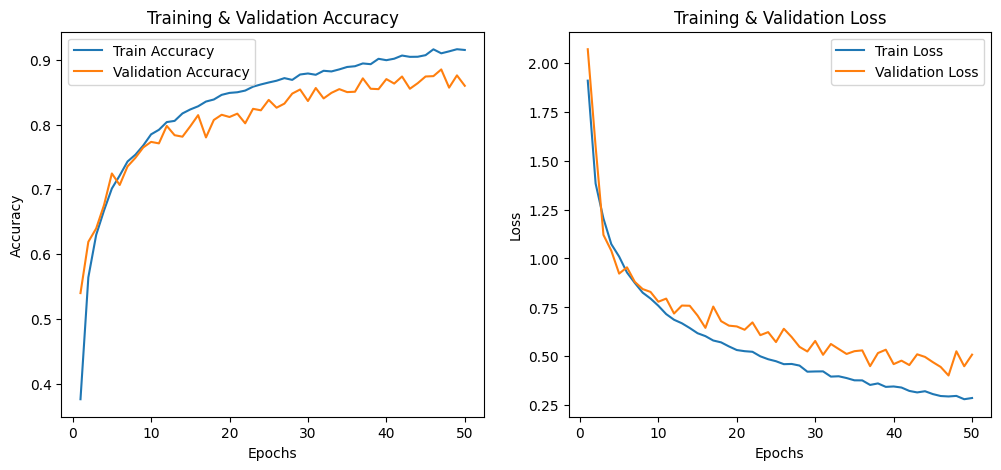

In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# ------------------- Load Pre-trained ESC-50 Model -------------------
CNN2_LM_MFCC_esc50_model_path = "/content/drive/MyDrive/Colab Notebooks/Dataset/ESC-50-master/CNN2_LM_MFCC_esc50_model.h5"

if not os.path.exists(CNN2_LM_MFCC_esc50_model_path):
    raise FileNotFoundError(f"ESC-50 trained model not found at: {CNN2_LM_MFCC_esc50_model_path}")

base_model = load_model(CNN2_LM_MFCC_esc50_model_path)

# Define an explicit input layer (same as ESC-50 input shape)
input_layer = Input(shape=(128, 128, 2))  # (Log-Mel Spectrogram + MFCC)

# Pass the input through the pre-trained model
x = base_model(input_layer, training=False)  # Freezes pre-trained layers

# Modify the last layers for UrbanSound8K (10 classes)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
out = Dense(10, activation='softmax')(x)  # 10 classes for UrbanSound8K

# Create the new model
urban_model = Model(inputs=input_layer, outputs=out)

# Compile the fine-tuned model
urban_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

print("UrbanSound8K model successfully built!")

# ------------------- Process UrbanSound8K Dataset -------------------

urbansound_csv = "/content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/metadata/UrbanSound8K.csv"
urbansound_audio_dir = "/content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/audio"

urbansound_metadata = pd.read_csv(urbansound_csv)

def extract_features(file_path, sr=22050, n_mels=128, n_mfcc=40, target_size=(128, 128)):
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return None
    try:
        y, sr = librosa.load(file_path, sr=sr, duration=3.0)

        # Skip very short audio
        if len(y) < sr * 0.1:
            print(f"Skipping short audio file: {file_path}")
            return None

        # Compute Log-Mel Spectrogram
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

        # Compute MFCC
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

        # Resize both to (128, 128)
        mel_spec_resized = tf.image.resize(np.expand_dims(mel_spec, axis=-1), target_size).numpy()
        mfcc_resized = tf.image.resize(np.expand_dims(mfcc, axis=-1), target_size).numpy()

        # Stack LM and MFCC along the channel axis
        stacked_features = np.dstack((mel_spec_resized, mfcc_resized))

        return stacked_features
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

# ------------------- Load and Process UrbanSound8K Dataset -------------------

X_urban, y_urban = [], []
print("Processing UrbanSound8K dataset...")

for i in tqdm(range(len(urbansound_metadata))):
    file_path = os.path.join(urbansound_audio_dir, f"fold{urbansound_metadata.loc[i, 'fold']}", urbansound_metadata.loc[i, "slice_file_name"])
    label = urbansound_metadata.loc[i, "classID"]
    features = extract_features(file_path)

    if features is not None:
        X_urban.append(features)
        y_urban.append(label)

if len(X_urban) == 0:
    raise RuntimeError("No valid UrbanSound8K audio files processed.")

# Convert dataset to NumPy arrays
X_urban = np.array(X_urban)
y_urban = to_categorical(y_urban, num_classes=10)

# Split dataset into training and test sets
X_train_urban, X_test_urban, y_train_urban, y_test_urban = train_test_split(X_urban, y_urban, test_size=0.2, random_state=42)

# ------------------- Fine-Tune the Model -------------------
history_urban = urban_model.fit(X_train_urban, y_train_urban, epochs=50, batch_size=32, validation_data=(X_test_urban, y_test_urban))

# Save the fine-tuned model
urban_model.save("/content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/CNN2_LM_MFCC_ESC50_UrbanSound8k_model.h5")
print("Fine-tuned UrbanSound8K model saved successfully!")

# ------------------- Plot Training Results -------------------
import matplotlib.pyplot as plt

def plot_training_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'tab:blue', label='Train Accuracy')
    plt.plot(epochs, val_acc, 'tab:orange', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'tab:blue', label='Train Loss')
    plt.plot(epochs, val_loss, 'tab:orange', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()

    plt.show()

# Call the function to plot results
plot_training_results(history_urban)


In [ ]:
# Evaluate model on training data
train_loss, train_accuracy = urban_model.evaluate(X_train_urban, y_train_urban, verbose=0)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Evaluate model on test data
test_loss, test_accuracy = urban_model.evaluate(X_test_urban, y_test_urban, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get predictions
y_pred_probs = urban_model.predict(X_test_urban)  # Get probability outputs
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Convert to class labels
y_true_classes = np.argmax(y_test_urban, axis=1)  # Convert one-hot encoded labels to class labels


from sklearn.metrics import precision_score, recall_score, f1_score


# Compute precision, recall, and F1-score
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

# Print evaluation metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


# Ensure the import is available
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Debugging step: Check class labels before computing classification report
print("y_true_classes:", type(y_true_classes), y_true_classes.shape)
print("y_pred_classes:", type(y_pred_classes), y_pred_classes.shape)

# Compute classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=[str(i) for i in range(10)])

print("\nClassification Report:\n")
print(report)
print(f"Final Test Accuracy (from classification report): {accuracy_score(y_true_classes, y_pred_classes):.4f}")



Training Accuracy: 0.8970
Test Accuracy: 0.8597
55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 239ms/step
Precision: 0.8698
Recall: 0.8597
F1 Score: 0.8600
y_true_classes: <class 'numpy.ndarray'> (1746,)
y_pred_classes: <class 'numpy.ndarray'> (1746,)

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.86      0.89       215
           1       0.97      0.75      0.84        79
           2       0.73      0.78      0.75       178
           3       0.93      0.72      0.81       209
           4       0.88      0.90      0.89       212
           5       0.87      0.93      0.90       204
           6       0.98      0.94      0.96        68
           7       0.87      0.96      0.91       191
           8       0.95      0.82      0.88       170
           9       0.73      0.91      0.81       220

    accuracy                           0.86      1746
   macro avg       0.88      0.86      0.87      1746
weighted avg       0.87      0.86  

UrbanSound8K model successfully built!
Processing UrbanSound8K dataset...


 24%|██▍       | 2123/8732 [20:39<43:57,  2.51it/s]

Skipping short audio file: /content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/audio/fold3/151359-1-2-0.wav


 41%|████      | 3556/8732 [34:24<41:33,  2.08it/s]

Skipping short audio file: /content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/audio/fold2/17307-1-0-0.wav


 95%|█████████▌| 8327/8732 [1:19:26<02:50,  2.38it/s]

Skipping short audio file: /content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/audio/fold1/87275-1-1-0.wav


 95%|█████████▌| 8328/8732 [1:19:26<02:39,  2.53it/s]

Skipping short audio file: /content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/audio/fold1/87275-1-2-0.wav


 95%|█████████▌| 8329/8732 [1:19:26<02:29,  2.69it/s]

Skipping short audio file: /content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/audio/fold1/87275-1-3-0.wav


 95%|█████████▌| 8330/8732 [1:19:27<02:21,  2.83it/s]

Skipping short audio file: /content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/audio/fold1/87275-1-4-0.wav


100%|██████████| 8732/8732 [1:22:58<00:00,  1.75it/s]


Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 142s 627ms/step - accuracy: 0.2327 - loss: 2.3353 - val_accuracy: 0.5401 - val_loss: 2.0755
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 131s 597ms/step - accuracy: 0.5368 - loss: 1.4371 - val_accuracy: 0.6168 - val_loss: 1.5656
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 143s 655ms/step - accuracy: 0.6400 - loss: 1.1794 - val_accuracy: 0.6598 - val_loss: 1.1132
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 202s 657ms/step - accuracy: 0.6686 - loss: 1.0848 - val_accuracy: 0.6844 - val_loss: 1.0305
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 143s 655ms/step - accuracy: 0.7060 - loss: 0.9930 - val_accuracy: 0.7090 - val_loss: 0.9498
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 203s 659ms/step - accuracy: 0.7174 - loss: 0.9531 - val_accuracy: 0.7291 - val_loss: 0.9336
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 197s 636ms/step - accuracy: 0.7639 - loss: 0.8419 - val_accuracy: 0.7480 - val_loss: 0.8371
Epoch 8/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 142s 638ms/step - accuracy: 0.7662 -

Fine-tuned UrbanSound8K model saved successfully!


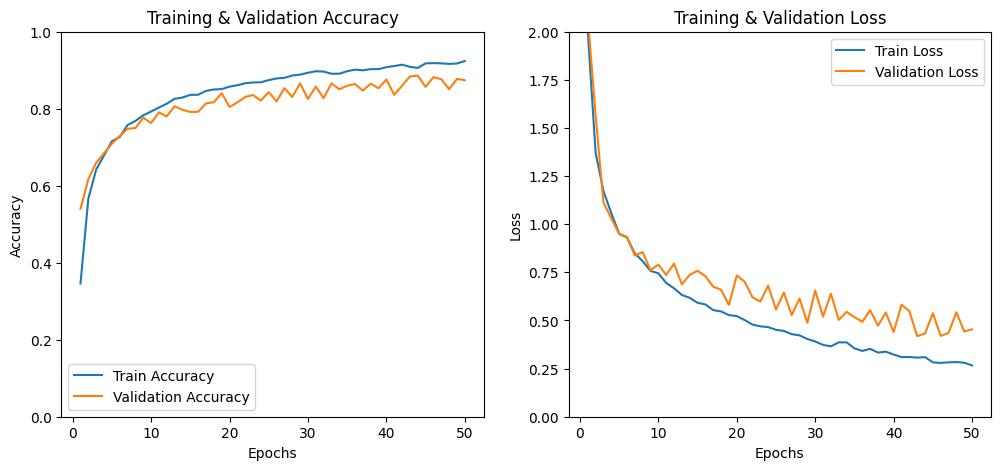

NameError: name 'history' is not defined

In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# ------------------- Load Pre-trained ESC-50 Model -------------------
CNN2_LM_MFCC_esc50_model_path = "/content/drive/MyDrive/Colab Notebooks/Dataset/ESC-50-master/CNN2_LM_MFCC_esc50_model.h5"

if not os.path.exists(CNN2_LM_MFCC_esc50_model_path):
    raise FileNotFoundError(f"ESC-50 trained model not found at: {CNN2_LM_MFCC_esc50_model_path}")

base_model = load_model(CNN2_LM_MFCC_esc50_model_path)

# Define an explicit input layer (same as ESC-50 input shape)
input_layer = Input(shape=(128, 128, 2))  # (Log-Mel Spectrogram + MFCC)

# Pass the input through the pre-trained model
x = base_model(input_layer, training=False)  # Freezes pre-trained layers

# Modify the last layers for UrbanSound8K (10 classes)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
out = Dense(10, activation='softmax')(x)  # 10 classes for UrbanSound8K

# Create the new model
urban_model = Model(inputs=input_layer, outputs=out)

# Compile the fine-tuned model
urban_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

print("UrbanSound8K model successfully built!")

# ------------------- Process UrbanSound8K Dataset -------------------

urbansound_csv = "/content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/metadata/UrbanSound8K.csv"
urbansound_audio_dir = "/content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/UrbanSound8K/audio"

urbansound_metadata = pd.read_csv(urbansound_csv)

def extract_features(file_path, sr=22050, n_mels=128, n_mfcc=40, target_size=(128, 128)):
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return None
    try:
        y, sr = librosa.load(file_path, sr=sr, duration=3.0)

        # Skip very short audio
        if len(y) < sr * 0.1:
            print(f"Skipping short audio file: {file_path}")
            return None

        # Compute Log-Mel Spectrogram
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

        # Compute MFCC
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

        # Resize both to (128, 128)
        mel_spec_resized = tf.image.resize(np.expand_dims(mel_spec, axis=-1), target_size).numpy()
        mfcc_resized = tf.image.resize(np.expand_dims(mfcc, axis=-1), target_size).numpy()

        # Stack LM and MFCC along the channel axis
        stacked_features = np.dstack((mel_spec_resized, mfcc_resized))

        return stacked_features
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

# ------------------- Load and Process UrbanSound8K Dataset -------------------

X_urban, y_urban = [], []
print("Processing UrbanSound8K dataset...")

for i in tqdm(range(len(urbansound_metadata))):
    file_path = os.path.join(urbansound_audio_dir, f"fold{urbansound_metadata.loc[i, 'fold']}", urbansound_metadata.loc[i, "slice_file_name"])
    label = urbansound_metadata.loc[i, "classID"]
    features = extract_features(file_path)

    if features is not None:
        X_urban.append(features)
        y_urban.append(label)

if len(X_urban) == 0:
    raise RuntimeError("No valid UrbanSound8K audio files processed.")

# Convert dataset to NumPy arrays
X_urban = np.array(X_urban)
y_urban = to_categorical(y_urban, num_classes=10)

# Split dataset into training and test sets
X_train_urban, X_test_urban, y_train_urban, y_test_urban = train_test_split(X_urban, y_urban, test_size=0.2, random_state=42)

# ------------------- Fine-Tune the Model -------------------
history_urban = urban_model.fit(X_train_urban, y_train_urban, epochs=50, batch_size=32, validation_data=(X_test_urban, y_test_urban))

# Save the fine-tuned model
urban_model.save("/content/drive/MyDrive/Colab Notebooks/Dataset/UrbanSound8K/CNN2_LM_MFCC_ESC50_UrbanSound8k_model.h5")
print("Fine-tuned UrbanSound8K model saved successfully!")

# ------------------- Plot Training Results -------------------
import matplotlib.pyplot as plt

def plot_training_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'tab:blue', label='Train Accuracy')
    plt.plot(epochs, val_acc, 'tab:orange', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)  # Set y-axis range for accuracy
    plt.title('Training & Validation Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'tab:blue', label='Train Loss')
    plt.plot(epochs, val_loss, 'tab:orange', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0, 2)  # Set y-axis range for loss
    plt.title('Training & Validation Loss')
    plt.legend()

    plt.show()

# Call the function to plot results
plot_training_results(history_urban)


# SAVE CNN1 HISTORY AFTER TRAINING
import numpy as np

np.save("/content/drive/MyDrive/Colab Notebooks/Models/Result/cnn2_LM_MFCC_train_acc.npy", history.history['accuracy'])
np.save("/content/drive/MyDrive/Colab Notebooks/Models/Result/cnn2_LM_MFCC_val_acc.npy", history.history['val_accuracy'])
np.save("/content/drive/MyDrive/Colab Notebooks/Models/Result/cnn2_LM_MFCC_train_loss.npy", history.history['loss'])
np.save("/content/drive/MyDrive/Colab Notebooks/Models/Result/cnn2_LM_MFCC_val_loss.npy", history.history['val_loss'])

print("CNN2 training history saved!")


In [ ]:
# SAVE CNN1 HISTORY AFTER TRAINING
import numpy as np

np.save("/content/drive/MyDrive/Colab Notebooks/Models/Result/cnn2_LM_MFCC_train_acc.npy", history_urban.history['accuracy'])
np.save("/content/drive/MyDrive/Colab Notebooks/Models/Result/cnn2_LM_MFCC_val_acc.npy", history_urban.history['val_accuracy'])
np.save("/content/drive/MyDrive/Colab Notebooks/Models/Result/cnn2_LM_MFCC_train_loss.npy", history_urban.history['loss'])
np.save("/content/drive/MyDrive/Colab Notebooks/Models/Result/cnn2_LM_MFCC_val_loss.npy", history_urban.history['val_loss'])

print("CNN2 training history saved!")

CNN2 training history saved!
